# FDM Assignment

Assignment description:

The task of this assignment is to simulate flow to a well near a river with **MDFLOW ** , The river is absolutely long and 250 meters wide, runing N-S direction. The resistence of the river is equial to **c** , The well is located approximately 800 meters East of the eastern river bank. **The discharge of the pumping well is 1000 m^3/d. The water level in the river is equal to 10 m. Transmisivity of the aquifer is approximated as constant everywhere and equal to 200 m^2/d. Before pumping, the head was equal to 10 meters everywhere.** 

### Question 1. set resistence as 100d and make a contour plot 

####  Model Set-up

In [1]:
%matplotlib inline
from pylab import *
import flopy.modflow as mf
import flopy.utils as fu
import flopy.plot as fp

In [2]:
import os
workspace = os.path.join('AS2')
# make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)

Guidelines of building the model:

1. Create a MODFLOW model object
2. Define the discretization of the model
3. Define 'basic' model features, specifically which cells are inactive
4. Define the properties of the aquifer layers and, if present, leaky layers
5. Add packages to the MODFLOW model so simulate aquifer features
6. Define the solver that MODFOW uses to solve the model
7. Define what output MODFLOW needs to save to a file
8. Generate MODFLOW input files and solve the model (this will call the MODFLOW executable on your machine)
9. Read the binary output and display it

**1. Creat a MODFLOW model object**

In [3]:
import platform
binpath = 'C:/Users/13319/Documents/Python Jupyter/Geo-hydrology/groundwater modelling'  # Yes, also use forward slashes in Windows here
exe_name = os.path.join(binpath, 'mf2005')
if platform.system() == 'Windows':
    exe_name += '.exe'
print('Model executable: ', exe_name)

Model executable:  C:/Users/13319/Documents/Python Jupyter/Geo-hydrology/groundwater modelling\mf2005.exe


In [4]:
modelname = 'fd4'
ml = mf.Modflow(modelname=modelname,
                exe_name=exe_name,
                model_ws=workspace)

**2. Discretize the domain**

In [5]:
nlay = 1
nrow = 81
ncol = 81
delr = 50
delc = 50
top = 0.0
botm = -20
dis = mf.ModflowDis(ml,
                    nlay=nlay,
                    nrow=nrow,
                    ncol=ncol,
                    delr=delr,
                    delc=delc,
                    top=top,
                    botm=botm,
                    laycbd=1,
                    )

**3. Define Basic Features**

In [6]:
# as in leaky bottom of river, no fixed head is specified
bas = mf.ModflowBas(ml)

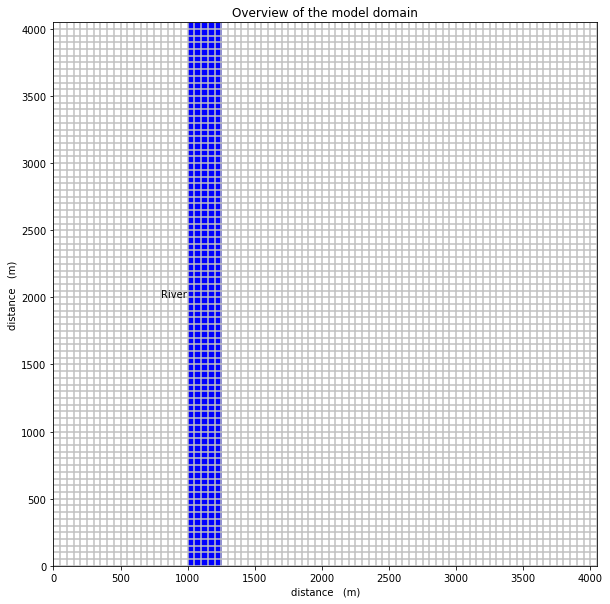

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = fp.ModelMap(model=ml)
modelmap.plot_ibound()
import matplotlib
ax.add_patch(matplotlib.patches.Rectangle((1000,0),250,4050,color='b'))
plt.text(800,2000,"River")
plt.title("Overview of the model domain")
plt.xlabel("distance   (m)")
plt.ylabel("distance   (m)")
modelmap.plot_grid(colors='silver');

**4. Set aquifer properties**

In [8]:
k = 10
lpf = mf.ModflowLpf(ml, hk=k)

**5. Add additional features into package**

In [9]:
discharge_data ={0: [[0, 40, 41, -1000]]}
wel = mf.ModflowWel(ml, stress_period_data=discharge_data)
bc = np.array([[0,0,0,10,50*50/100]]*nrow*5).reshape(nrow,5,5)
for j in range(5):
    for i in range(nrow):
        bc[i,j,:][1] = i
        bc[i,j,:][2] = j+20
bc = bc.reshape(nrow*5,5)
ghb_data ={0: bc}
ghb = mf.ModflowGhb(ml, stress_period_data=ghb_data)

**6. Define a solver **

In this case, conjugate gradient method is ultilized.

In [10]:
pcg = mf.ModflowPcg(ml)

**7. Output control**

In [11]:
oc = mf.ModflowOc(ml) 

**8. Write input file and run model**

In [12]:
ml.write_input()
ml.run_model()

FloPy is using the following executable to run the model: C:/Users/13319/Documents/Python Jupyter/Geo-hydrology/groundwater modelling\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: fd4.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/06/23 23:08:01

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/06/23 23:08:01
 Elapsed run time:  0.040 Seconds

  Normal termination of simulation


(True, [])

**9. Read data and analyse it**

In [13]:
modelname = 'fd4'
headfile = fu.HeadFile(os.path.join(workspace, modelname+'.hds'))
h = headfile.get_data(totim=1.0)
print('shape of h:', np.shape(h))
print('min,max of h:', h[0].min(), h[0].max())

shape of h: (1, 81, 81)
min,max of h: 5.51048 9.95652


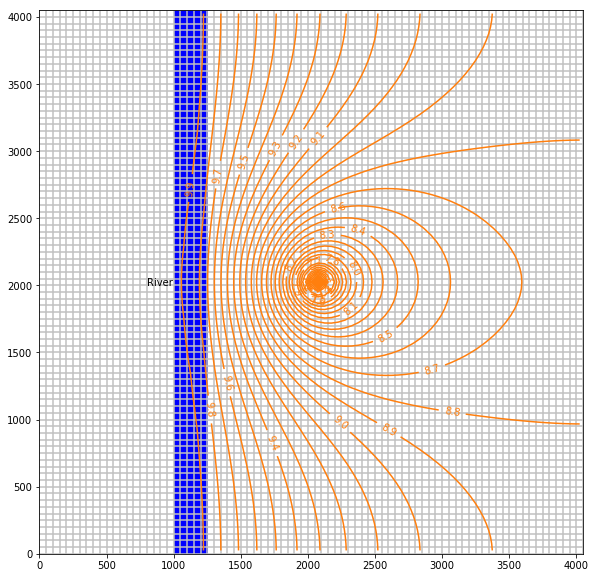

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.axis(aspect='equal')
modelmap = fp.ModelMap(model=ml)
modelmap.plot_grid(colors='silver')
modelmap.plot_ibound(color_ch = 'green')
ax.add_patch(matplotlib.patches.Rectangle((1000,0),250,4050,color='b'))
plt.text(800,2000,"River")
cs = modelmap.contour_array(h[0], levels=np.arange(1, 10, 0.1), colors='C1')
plt.clabel(cs, fmt='%1.1f');

###  Question 2.

** Compute the head in the cell containing the well with six different values of bottom resistence c:10,20,40,80,160,320 and 640 days. Make a graph with the resistence along the horizontal axis and the head in the cell containing the well along vertical axis**

In [15]:
C = np.array([10,20,40,80,160,320,640])
h = []
discharge_data ={0: [[0, 40, 41, -1000]]}
wel = mf.ModflowWel(ml, stress_period_data=discharge_data)
for i in range(len(C)):
    bc = np.array([[0,0,0,10,50*50/C[i]]]*nrow*5).reshape(nrow,5,5)
    for j in range(5):
        for i in range(nrow):
            bc[i,j,:][1] = i
            bc[i,j,:][2] = j+20
    bc = bc.reshape(nrow*5,5)
    ghb_data ={0: bc}
    ghb = mf.ModflowGhb(ml, stress_period_data=ghb_data)
    ml.write_input()
    ml.run_model(silent=True)
    h.append(headfile.get_data(totim=1.0))

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfghb.ModflowGhb'> <class 'flopy.modflow.mfghb.ModflowGhb'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfghb.ModflowGhb'> <class 'flopy.modflow.mfghb.ModflowGhb'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfghb.ModflowGhb'> <class 'flopy.modflow.mfghb.ModflowGhb'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfghb.ModflowGhb'> <class 'flopy.modflow.mfghb.ModflowGhb'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfghb.ModflowGhb'> <class 'flopy.modflow.mfghb.ModflowGhb'>
replacing existing Package...
****Warning -- two packages of the same type: 

In [16]:
h_well = [h[i][0][40,41] for i in range(len(C))]

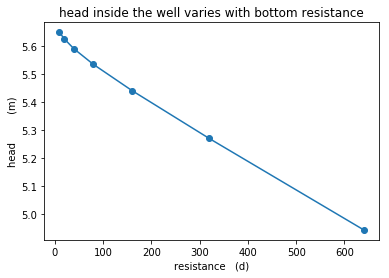

In [21]:
plt.plot(C,h_well,marker='o')
plt.title("head inside the well varies with bottom resistance")
plt.xlabel("resistance   (d)")
plt.ylabel("head         (m)");